In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import netCDF4 as nc
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.mpl.gridliner 
# import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.mpl.ticker as cticker
import cartopy.io.shapereader as shpreader
import math
from math import sqrt

from matplotlib import colors,cm
import matplotlib as mpl
import cmaps
from matplotlib.colors import ListedColormap 
from scipy.stats import pearsonr

file_vwnd = './dataset/V-WIND.nc'
file_uwnd = './dataset/U-WIND.nc'
dataset_vwnd = nc.Dataset(file_vwnd)
dataset_uwnd = nc.Dataset(file_uwnd)
# vwnd(time, level, lat, lon) current shape = (904, 17, 73, 144)
vlon, vlat = dataset_vwnd.variables['lon'], dataset_vwnd.variables['lat']
vtime = dataset_vwnd.variables['time']
vlevel =dataset_vwnd.variables['level']
vwnd = dataset_vwnd.variables['vwnd']

ulon, ulat = dataset_uwnd.variables['lon'], dataset_vwnd.variables['lat']
utime = dataset_uwnd.variables['time']
ulevel =dataset_uwnd.variables['level']
uwnd = dataset_uwnd.variables['uwnd']


cor_num = pd.read_excel(io = r'./dataset/SI0922.xlsx')
coordinate = cor_num['5AV.SI'].tolist()


In [2]:
# 求level在850处的涡度
# |delta v / |delta x - |delta u / |delta y
# 因为纬度lat有地球偏差 x = x * cos(lat) * 111
# 每一年计算一个涡度，每个点在时间序列上有40个涡度值
# 对每个点进行相关计算
vlevel_850 = vwnd[:1,2:3].data[0][:,:][0]
ulevel_850 = uwnd[:1,2:3].data[0][:,:][0]

In [3]:
# 计算相邻两点之间的绝对距离 lat纬度 lon经度
lat = vlat[:].data
Y_derivative = abs((lat[2]-lat[0])*111)
lon = vlon[:].data
X_derivative = (lon[2]-lon[0])*111
print(X_derivative, Y_derivative)

# 计算涡度需要上面那个点 因此上下都多一行
# vwind_mid = vwnd[:1,2:3,18:55,:].data[0][0] 
vwind_mid = vwnd[:1,2:3,17:56,:].data[0][0] 
uwind_mid = uwnd[:1,2:3,17:56,:].data[0][0] 

555.0 555.0


In [4]:
for i in range(lat.shape[0]):
    if lat[i] == 45.0 or lat[i] == -45.0:
        print(i)

18
54


In [6]:
def num_month_12toNext4(a):
    num_months = (a - 1948) * 12 
    start = num_months - 1
    end = start + 5
    if start <= 0:
        return print("Out Break!")
    else:
        return start, end

def vorticity_year(start, end):
    # start开始月份 end结束月分，num_month
    num_month = int(end-start)
    tmp_vorticity_year = np.zeros((37,144), dtype=float, order='C')
    for i in range(start, end):
        vwind_mid_tmp = vwnd[i:i+1,2:3,17:56,:].data[0][0]
        X_vorticity_tmp = X_vorticity(vwind_mid_tmp)  
        uwind_mid_tmp = uwnd[i:i+1,2:3,17:56,:].data[0][0] 
        Y_vorticity_tmp = Y_vorticity(uwind_mid_tmp)
        vorticity_tmp = X_vorticity_tmp - Y_vorticity_tmp
        tmp_vorticity_year += vorticity_tmp
    vorticity_mean = tmp_vorticity_year / num_month
    return vorticity_mean

def X_vorticity(vwind_mid):
    # 计算每个点的涡度 X_vorticity = dv / dx
    X_vorticity = np.zeros((37,144), dtype=float, order='C')
    # 从第1行计算到倒数第二行的涡度
    for row in range(1, vwind_mid.shape[0]-1):
        # 在row行的风数值
        vwind_lat = vwind_mid[row]
        # row行的lat纬度值
#         row_lat = lat[row+17]
    #     print(row, row+17)
        X_dis = X_derivative*math.cos(math.radians(lat[row-1]))
        for i in range(len(vwind_lat)):
            if i<=len(vwind_lat)-2:
                X_vorticity[row-1][i] = (vwind_lat[i+1]-vwind_lat[i-1])/X_dis
            elif i == len(vwind_lat)-1:
                X_vorticity[row-1][i] = (vwind_lat[len(vwind_lat)-i]-vwind_lat[i-1])/X_dis
    return X_vorticity

def Y_vorticity(uwind_lat):
    # 计算 Y_vorticity = du/dy
    # 对于第一行的涡度，用第三行减去第一行，除以距离
    Y_vorticity = np.zeros((37,144), dtype=float, order='C')
    for i in range(1, 38):
        Y_vorticity[i-1] = (uwind_lat[i]-uwind_lat[i-2])/Y_derivative
    return Y_vorticity

def vorticity_mean(startYear, endYear):
    num_year = endYear-startYear
    vorticity_mean = np.zeros((num_year,37,144), dtype=float, order='C')
    for year in range(startYear, endYear):
        start, end = num_month_12toNext4(year)
        vort_tmp = vorticity_year(start, end)
#         print(vort_tmp)
        index = year - startYear
#         print(index)
        vorticity_mean[index:index+1,:,:] = vort_tmp
    return vorticity_mean

vor1980to2004 = vorticity_mean(1982, 2005)
vor2005to2023 = vorticity_mean(2011, 2022)

In [121]:
# 计算12月到次年4月的涡度 并进行转换
vorticity_1980to2004 = vor1980to2004.transpose(1,2,0)
vorticity_2005to2023 = vor2005to2023.transpose(1,2,0)

In [71]:
def PearsonMatrix(reshape_mean):
    pearson_matrix = np.zeros((37,144), dtype=float, order='C')
    p_value = np.zeros((37,144), dtype=float, order='C')
    for i in range(len(reshape_mean)):
        for j in range(len(reshape_mean[i])):
            x = reshape_mean[i][j]
            if len(x) == 25:
                y = coordinate[:25]
            elif len(x) == 19:
                y = coordinate[25:]
            else:
                break
                print("Error, the dimension x and y ")
            tmp_correlation, _ = pearsonr(x, y)
    #         print(tmp_correlation)
            pearson_matrix[i][j] = tmp_correlation
            p_value[i][j] = _
    pearson_matrix = np.nan_to_num(pearson_matrix)
    return pearson_matrix, p_value



In [122]:
# 计算相关性系数
pearson_matrix_1980to2004, p_value_1980to2004 = PearsonMatrix(vorticity_1980to2004)
pearson_matrix_2005to2023, p_value_2005to2023 = PearsonMatrix(vorticity_2005to2023)

In [123]:
# 求相关行系数的最大值和最小值
print(pearson_matrix_1980to2004.max(), pearson_matrix_1980to2004.min())
print(pearson_matrix_2005to2023.max(), pearson_matrix_2005to2023.min())

0.7412334446341317 -0.7857120002928568
0.6783580904795331 -0.6568263288620279


In [124]:
print(p_value_1980to2004.max(), p_value_1980to2004.min())
print(p_value_2005to2023.max(), p_value_2005to2023.min())

0.999986843850292 3.259756018269397e-06
0.999805358866297 0.00141001836129494


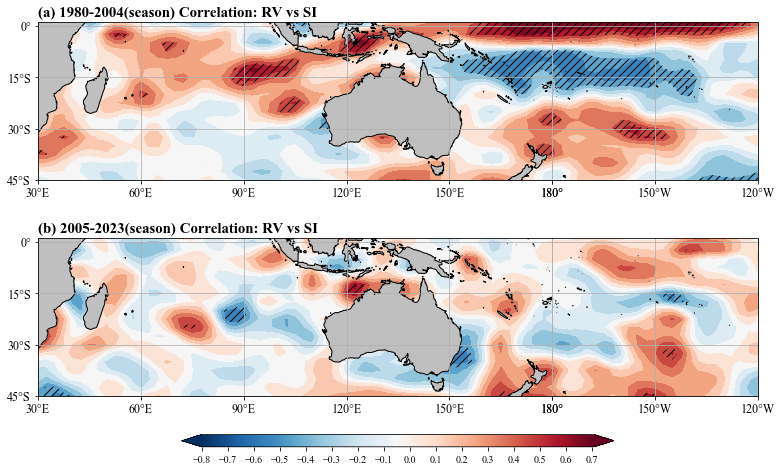

In [127]:
from matplotlib.font_manager import FontProperties

plt.rc('font',family='Times New Roman') 
# 纬度转换成太平洋为中心，增加360度一度
lon = np.append(vlon[:].data, [360.0])
# lon = vlon[:].data
# 取经度数据
lat = vlat[18:55].data

# new_diff = pearson_matrix
diff_2d = pearson_matrix_1980to2004
# print(diff_2d)
# 对diff进行转换本初子午线为中心 为 太平洋为中心
new_diff_1980to2004=[]
for i in range(diff_2d.shape[0]):
    tmp = np.append(diff_2d[i], diff_2d[i][0])
    new_diff_1980to2004.append(tmp.tolist())
new_diff_1980to2004 = np.array(new_diff_1980to2004)

MAX = 0.71
MIN = -0.8

fig = plt.figure(figsize=(10,10))

proj = ccrs.PlateCarree(central_longitude=180)
# proj = ccrs.PlateCarree()
leftlon, rightlon, lowerlat, upperlat = (30, 180.1, -45, 1)
lon_formatter = cticker.LongitudeFormatter()
lat_formatter = cticker.LatitudeFormatter()
fig_ax1 = fig.add_axes([0, 0.4, 1, 1], projection = proj)

fig_ax1.contourf(vlon[:].data, lat, p_value_1980to2004,
                [np.nanmin(p_value_1980to2004), 0.05, np.nanmax(p_value_1980to2004)],
#                  [0.01, 0.05, np.nanmax(p_value)],
                hatches=['///', None], colors="none",
                transform = ccrs.PlateCarree()) # 增加斜线

fig_ax1.set_extent([leftlon, rightlon, lowerlat, upperlat], crs=ccrs.PlateCarree())
land = cfeature.NaturalEarthFeature('physical','land','50m',edgecolor='face', facecolor=cfeature.COLORS['land'])
fig_ax1.add_feature(land,facecolor='0.75')
fig_ax1.add_feature(cfeature.COASTLINE.with_scale('50m'))
xticks_list = np.hstack((np.arange(30,180.1,30) , np.arange(-180,-90.1,30)))
fig_ax1.set_xticks(xticks_list, crs=ccrs.PlateCarree())
fig_ax1.set_yticks(np.arange(-45,1,15), crs=ccrs.PlateCarree())
labels = fig_ax1.get_xticklabels() + fig_ax1.get_yticklabels()
[label.set_fontproperties(FontProperties(fname="./font/times.ttf",size=12)) for label in labels]

fig_ax1.grid() # 增加网格

fig_ax1.xaxis.set_major_formatter(lon_formatter)
fig_ax1.yaxis.set_major_formatter(lat_formatter)

fig_ax1.set_title('(a) 1980-2004(season) Correlation: RV vs SI',fontweight='bold',
                  loc='left',fontsize =15)

cont_ax1 = fig_ax1.contourf(lon, lat, new_diff_1980to2004, 
                 levels=np.arange(MIN,MAX,0.1), # 颜色分片
                        zorder=0,
                transform=ccrs.PlateCarree(),
                        cmap=plt.cm.RdBu_r
#                         cmap=cmaps.BlueWhiteOrangeRed
                       )

# ======================= 图2 =============================
diff_3d = pearson_matrix_2005to2023
# print(diff_2d)
# 对diff进行转换本初子午线为中心 为 太平洋为中心
new_diff_2004to2022=[]
for i in range(diff_3d.shape[0]):
    tmp = np.append(diff_3d[i], diff_3d[i][0])
    new_diff_2004to2022.append(tmp.tolist())
new_diff_2004to2022 = np.array(new_diff_2004to2022)

fig_ax2 = fig.add_axes([0, 0.1, 1, 1], projection = proj)

fig_ax2.contourf(vlon[:].data, lat, p_value_2005to2023,
                [np.nanmin(p_value_2005to2023), 0.05, np.nanmax(p_value_2005to2023)],
#                  [0.01, 0.08, np.nanmax(p_value)],
                hatches=['///', None], colors="none",
                transform = ccrs.PlateCarree()) # 增加斜线

fig_ax2.set_extent([leftlon, rightlon, lowerlat, upperlat], crs=ccrs.PlateCarree())
land = cfeature.NaturalEarthFeature('physical','land','50m',edgecolor='face', facecolor=cfeature.COLORS['land'])
fig_ax2.add_feature(land,facecolor='0.75')
fig_ax2.add_feature(cfeature.COASTLINE.with_scale('50m'))
fig_ax2.set_xticks(xticks_list, crs=ccrs.PlateCarree())
fig_ax2.set_yticks(np.arange(-45,1,15), crs=ccrs.PlateCarree())
labels = fig_ax2.get_xticklabels() + fig_ax2.get_yticklabels()
[label.set_fontproperties(FontProperties(fname="./font/times.ttf",size=12)) for label in labels]

fig_ax2.grid() # 增加网格

fig_ax2.xaxis.set_major_formatter(lon_formatter)
fig_ax2.yaxis.set_major_formatter(lat_formatter)

fig_ax2.set_title('(b) 2005-2023(season) Correlation: RV vs SI',fontweight='bold',
                  loc='left',fontsize =15)

cont_ax1 = fig_ax2.contourf(lon, lat, new_diff_2004to2022, 
                 levels=np.arange(MIN,MAX,0.1), # 颜色分片
                        zorder=0,
                transform=ccrs.PlateCarree(),
                        cmap=plt.cm.RdBu_r
#                         cmap=cmaps.BlueWhiteOrangeRed
                       )

position = fig.add_axes([0.2, 0.42, 0.6, 0.017]) # 最下面位置

norm = colors.Normalize(vmin=MIN, vmax=MAX)    #确定colormap的最大最小值

fc1=fig.colorbar(mpl.cm.ScalarMappable(norm=norm,
                                       cmap=plt.cm.RdBu_r
                                      ),
                 cax = position,
                 orientation='horizontal',
                 ticks=np.arange(MIN,MAX,0.1).tolist(), # colorbar分片                                                 
                 extend='both',
#                  label =mul_symbol_text+'1e+06',
                fraction=0.012) 

font = {'family' : 'Times New Roman',
        'weight' : 'normal',
        'size'   : 12,
        }
fc1.set_label(label="", fontdict=font) #设置colorbar的标签字体及其大小

plt.savefig("wnd_vorticity_12toNext4.png",dpi=200,bbox_inches='tight')
plt.show()